In [1]:
import ee
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import folium

ee.Authenticate(scopes=[
    'https://www.googleapis.com/auth/earthengine',
    'https://www.googleapis.com/auth/drive'],
     quiet=False
)

# Initialize the library.
ee.Initialize(project='argon-magnet-458217-k5')

In [6]:
# 2. Cargar polígono con geopandas
gdf = gpd.read_file('cuenca.shp') # considerar EPsg 4326
geom = gdf.geometry.iloc[0]                         
geometry = ee.Geometry(geom.__geo_interface__)      
# 1) Obtén el bounding box como un EE.Geometry.Polygon
geometry = geometry.bounds()# convierto a EE


In [47]:
# 1) Toma la primera imagen de la colección sin filtros
first = ee.ImageCollection('NASA/HLS/HLSL30/v002').first()

# 2) Pide sus nombres de banda (muy rápido)
bands = first.bandNames().getInfo()

print(f"Número de bandas: {len(bands)}")
print("Bandas:", bands)
# 1) Comprueba el nombre de propiedades de la primera imagen
props = ee.ImageCollection('NASA/HLS/HLSL30/v002').first() \
          .propertyNames().getInfo()
print("Propiedades disponibles:", props)

Número de bandas: 15
Bandas: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'B10', 'B11', 'Fmask', 'SZA', 'SAA', 'VZA', 'VAA']
Propiedades disponibles: ['system:version', 'system:id', 'B6_scale', 'B11_scale', 'B1_scale', 'HLS_PROCESSING_TIME', 'MEAN_SUN_AZIMUTH_ANGLE', 'B4_scale', 'SAA_scale', 'TIRS_SSM_MODEL', 'MEAN_VIEW_AZIMUTH_ANGLE', 'system:footprint', 'MEAN_SUN_ZENITH_ANGLE', 'CLOUD_COVERAGE', 'B2_scale', 'B7_scale', 'B10_scale', 'SPATIAL_COVERAGE', 'system:time_end', 'LANDSAT_PRODUCT_ID', 'B5_scale', 'SZA_scale', 'system:time_start', 'B9_scale', 'VZA_scale', 'ACCODE', 'B3_scale', 'MEAN_VIEW_ZENITH_ANGLE', 'NBAR_SOLAR_ZENITH', 'USGS_SOFTWARE', 'system:asset_size', 'TIRS_SSM_POSITION_STATUS', 'VAA_scale', 'system:index', 'system:bands', 'system:band_names']


In [55]:
def maskFmask(image):
    fmask = image.select('Fmask')
    
    # Define máscaras para cada bit (1<<bit_position)
    bit_cirrus    = fmask.bitwiseAnd(1 << 0).eq(0)   # Bit 0: Cirrus
    bit_cloud     = fmask.bitwiseAnd(1 << 1).eq(0)   # Bit 1: Nube
    bit_adjacent  = fmask.bitwiseAnd(1 << 2).eq(0)   # Bit 2: Adyacente (nube/sombra)
    bit_shadow    = fmask.bitwiseAnd(1 << 3).eq(0)   # Bit 3: Sombra de nube
    bit_snow      = fmask.bitwiseAnd(1 << 4).eq(0)   # Bit 4: Nieve/hielo
    bit_water     = fmask.bitwiseAnd(1 << 5).eq(0)   # Bit 5: Agua

    # Combina todas: sólo conserva píxeles donde TODOS esos bits sean 0
    mask = bit_cirrus \
         .And(bit_cloud) \
         .And(bit_adjacent) \
         .And(bit_shadow) \
         .And(bit_snow) \
         .And(bit_water)
    
    return image.updateMask(mask)

# Ejemplo de uso sobre tu colección:
clean_col = (
    ee.ImageCollection('NASA/HLS/HLSL30/v002')
      .filterDate('2021-01-01', '2021-12-31')
      .filterBounds(geometry)
      .map(maskFmask)
)

# Comprueba cuántas imágenes quedan:
print("Imágenes tras enmascarar Fmask:", clean_col.size().getInfo())

Imágenes tras enmascarar Fmask: 200


In [56]:
col = (
    ee.ImageCollection('NASA/HLS/HLSL30/v002')
      .filterDate('2021-01-01', '2021-12-31')
      .filterBounds(geometry)
    # Filtra escenas con menos de 20% de nubes (ajusta el umbral a tu gusto)
      #.filter(ee.Filter.lt('CLOUD_COVERAGE', 5)),
      .map(maskFmask)
      # Primero elimina las escenas demasiado nubosas,
      # luego enmascara píxel a píxel las nubes restantes:
)
def maskClouds(image):
    # Fmask: 0 = clear, 1 = water, 2 = shadow, 3 = snow, 4 = cloud
    cloudMask = image.select('Fmask').eq(0)
    return image.updateMask(cloudMask)

# 2) Aplica la máscara a toda la colección original
col_cf = col
# 3) Función para añadir solo la banda NDVI y conservar la fecha
def addNDVI(image):
    ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    return ndvi.copyProperties(image, ['system:time_start'])

ndvi_col = col_cf.map(addNDVI)

# 4) Reducir en un solo paso para obtener media y desviación estándar
stats = ndvi_col.reduce(
    ee.Reducer.mean()
              .combine(
                reducer2=ee.Reducer.stdDev(),
                sharedInputs=True
              )
)

# 5) Separa y recorta las bandas resultantes
ndvi_mean = stats.select('NDVI_mean').clip(geometry)
ndvi_sd   = stats.select('NDVI_stdDev').clip(geometry)


In [57]:
# 1) Número de imágenes
n_images = ndvi_col.size().getInfo()
print(f"Número de imágenes en la colección: {n_images}")

# 2) Nombre de bandas (tomamos la primera imagen como ejemplo)
first_img = col.first()
band_names = first_img.bandNames().getInfo()
print(f"Número de bandas por imagen: {len(band_names)}")
print("Bandas:", band_names)

Número de imágenes en la colección: 200
Número de bandas por imagen: 15
Bandas: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'B10', 'B11', 'Fmask', 'SZA', 'SAA', 'VZA', 'VAA']


In [58]:
# Extrae las coordenadas de la región como lista de anillos
region_coords = geometry.bounds().getInfo()['coordinates']

# 1) Link de descarga para NDVI medio
url_mean = ndvi_mean.getDownloadURL({
    'scale': 100,
    'region': region_coords,
    'fileFormat': 'GeoTIFF'
})
print('URL de descarga NDVI Mean:', url_mean)

# 2) Link de descarga para NDVI desviación estándar
url_sd = ndvi_sd.getDownloadURL({
    'scale': 100,
    'region': region_coords,
    'fileFormat': 'GeoTIFF'
})
print('URL de descarga NDVI StdDev:', url_sd)


URL de descarga NDVI Mean: https://earthengine.googleapis.com/v1/projects/argon-magnet-458217-k5/thumbnails/99bc1a5eb98feba1418aceae68049e2a-b3bf5b53b6fcd726a931e0fc233bfd2f:getPixels
URL de descarga NDVI StdDev: https://earthengine.googleapis.com/v1/projects/argon-magnet-458217-k5/thumbnails/f1cca462edde6df40c6f03fc24cfe735-d64c8887b9f7b68f5e15d29691c09acd:getPixels


In [59]:
# 3) Adjunta la media de NDVI como propiedad de cada imagen
def attach_mean(image):
    mean_dict = image.select('NDVI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geometry,
        scale=100,
        maxPixels=1e13
    )
    return image.set('mean_ndvi', mean_dict.get('NDVI'))

ts_fc = ndvi_col.map(attach_mean)

# 4) Extrae listas paralelas de time_start y mean_ndvi
dates = ts_fc.aggregate_array('system:time_start').getInfo()
means = ts_fc.aggregate_array('mean_ndvi').getInfo()
print("Cantidad de fechas extraídas:", len(dates))
print("Cantidad de medios extraídos:", len(means))

# 5) Empareja y filtra los None
pairs = [(d, m) for d, m in zip(dates, means) if m is not None]
if not pairs:
    raise ValueError("Todas las medias NDVI son None. Quizás está todo enmascarado o fuera de rango.")

# 6) Crea el DataFrame
df = pd.DataFrame(pairs, columns=['time_ms', 'mean_ndvi'])
df['date'] = pd.to_datetime(df['time_ms'], unit='ms')
df = df.drop(columns='time_ms').sort_values('date').reset_index(drop=True)

# 7) Muestra primeros registros
print("Primeros 5 valores de NDVI medio:")
print(df.head())


Cantidad de fechas extraídas: 200
Cantidad de medios extraídos: 162
Primeros 5 valores de NDVI medio:
   mean_ndvi                date
0   0.702958 2021-01-03 14:40:07
1   0.730955 2021-01-03 14:40:07
2   0.764889 2021-01-03 14:40:31
3   0.644350 2021-01-03 14:40:31
4   0.717362 2021-01-12 14:33:52


In [61]:
# 1) Crea una columna sólo con la fecha (sin la hora)
df['day'] = df['date'].dt.floor('D')   # o df['date'].dt.date si prefieres objetos date

# 2) Agrupa por día y calcula la media de NDVI
daily = (
    df
    .groupby('day', as_index=False)['mean_ndvi']
    .mean()
    .rename(columns={'day':'date'})
)

print(daily)

         date  mean_ndvi
0  2021-01-03   0.710788
1  2021-01-12   0.724721
2  2021-01-19   0.695590
3  2021-01-28   0.692721
4  2021-02-04   0.735180
5  2021-02-13   0.724217
6  2021-02-20   0.735103
7  2021-03-01   0.712842
8  2021-03-08   0.719816
9  2021-03-17   0.689330
10 2021-03-24   0.711966
11 2021-04-02   0.719097
12 2021-04-09   0.712801
13 2021-04-18   0.700489
14 2021-04-25   0.741821
15 2021-05-04   0.719157
16 2021-05-11   0.716654
17 2021-05-20   0.706620
18 2021-05-27   0.672170
19 2021-06-05   0.712343
20 2021-06-12   0.718927
21 2021-06-21   0.651754
22 2021-06-28   0.694710
23 2021-07-07   0.695329
24 2021-07-14   0.700888
25 2021-07-23   0.673752
26 2021-07-30   0.702833
27 2021-08-08   0.686505
28 2021-08-24   0.712363
29 2021-08-31   0.691963
30 2021-09-09   0.675388
31 2021-09-16   0.672232
32 2021-09-25   0.672693
33 2021-10-02   0.714219
34 2021-10-11   0.667476
35 2021-10-18   0.722894
36 2021-10-27   0.713911
37 2021-11-03   0.724148
38 2021-11-07   0.712482


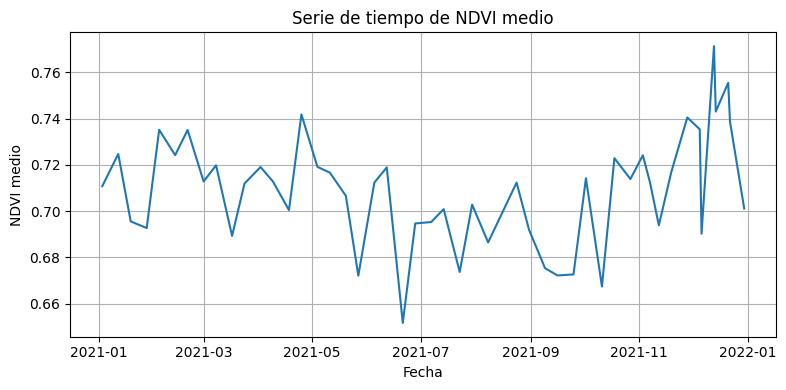

Tabla guardada en: ndvi_timeseries.csv


In [62]:
# 6) Grafica la serie de tiempo
plt.figure(figsize=(8,4))
plt.grid()
plt.plot(daily['date'], daily['mean_ndvi'])
plt.xlabel('Fecha')
plt.ylabel('NDVI medio')
plt.title('Serie de tiempo de NDVI medio')
plt.tight_layout()
plt.show()

# 7) Guarda toda la tabla en CSV
csv_path = 'ndvi_timeseries.csv'
df.to_csv(csv_path, index=False)
print(f"Tabla guardada en: {csv_path}")


Primeros 5 registros:
        date  mean_ndvi
0 2021-01-03   0.828846
1 2021-01-03   0.821550
2 2021-01-12   0.844519
3 2021-01-12   0.834962
4 2021-01-19   0.838313
Primeros 5 valores de la serie temporal:
        date  mean_ndvi
0 2021-01-03   0.828846
1 2021-01-03   0.821550
2 2021-01-12   0.844519
3 2021-01-12   0.834962
4 2021-01-19   0.838313


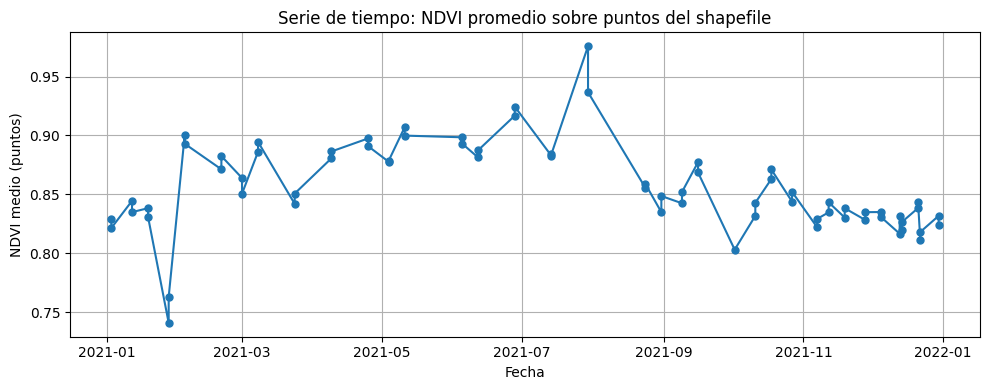

Tabla exportada a: ndvi_timeseries_puntos_shp.csv


In [63]:
# 1) Lee el CSV con 5 puntos (columnas lon, lat)
# 1) Carga tu shapefile de puntos y reproyecta a WGS84
gdf = gpd.read_file('puntos.shp').to_crs(epsg=4326)

# 2) Crea un FeatureCollection de EE con esos puntos
features = []
for idx, row in gdf.iterrows():
    lon, lat = row.geometry.x, row.geometry.y
    feat = ee.Feature(
        ee.Geometry.Point([lon, lat]),
        {'id': int(idx)}
    )
    features.append(feat)
points_fc = ee.FeatureCollection(features)

# 3) Función que para cada imagen de ndvi_col muestrea esos puntos y promedia
def sample_and_mean(image):
    samples = image.select('NDVI').sampleRegions(
        collection=points_fc,
        scale=100,
        geometries=False
    )
    mean_val = samples.aggregate_mean('NDVI')
    return ee.Feature(None, {
        'date': image.date().format('YYYY-MM-dd'),
        'mean_ndvi': mean_val
    })

# 4) Aplica la función sobre toda la colección
ts_fc = ndvi_col.map(sample_and_mean)

# 5) Trae los resultados a Python y filtra los nulos
features_list = ts_fc.getInfo()['features']
records = []
for f in features_list:
    props    = f['properties']
    date     = props.get('date')
    mean_ndvi = props.get('mean_ndvi')  # .get evita KeyError
    
    # Si no hay valor, saltar esta fecha
    if mean_ndvi is None:
        continue
    
    records.append({
        'date':      date,
        'mean_ndvi': mean_ndvi
    })

# 6) Construye el DataFrame
df = pd.DataFrame(records)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

print("Primeros 5 registros:")
print(df.head())
# 6) Construye el DataFrame y ordénalo
df = pd.DataFrame(records)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# 7) Muestra los primeros 5 registros
print("Primeros 5 valores de la serie temporal:")
print(df.head())

# 8) Grafica la serie de tiempo
plt.figure(figsize=(10,4))
plt.plot(df['date'], df['mean_ndvi'], '-o', markersize=5)
plt.xlabel('Fecha')
plt.ylabel('NDVI medio (puntos)')
plt.title('Serie de tiempo: NDVI promedio sobre puntos del shapefile')
plt.grid(True)
plt.tight_layout()
plt.show()

# 9) Guarda la serie completa en CSV
csv_out = 'ndvi_timeseries_puntos_shp.csv'
df.to_csv(csv_out, index=False)
print(f"Tabla exportada a: {csv_out}")